In [69]:
!pip install pmdarima --quiet

In [70]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm


import tensorflow as tf
from tensorflow.keras import layers

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitirme_1/keras/2/1/best_bilstm_model_2.keras
/kaggle/input/electric-consume/Generated_Data.csv


In [71]:
class config:
    dir_dataset = "/kaggle/input/electric-consume/Generated_Data.csv"
    

    target_feature = "TÜKETİM"

    find_sarimax_params = False
    
    # LSTM Parameters
    dir_atlstm_model = "/kaggle/input/bitirme_1/keras/2/1/best_bilstm_model_2.keras"
    create_atlstm_model = False
    window_size = 48
    forecast_horizon = 1

In [72]:
df = pd.read_csv(config.dir_dataset, header = 0, index_col = "TARİH", parse_dates = True)

print("Head of DataFrame \n")
print(df.head())
print("*"*100)
print("Tail of DataFrame \n")
print(df.tail())


Head of DataFrame 

                     Unnamed: 0    ÜRETİM  İTHALAT  İHRACAT   TÜKETİM
TARİH                                                                
2022-01-01 01:00:00        5016  31200.95   353.34    534.0  31020.29
2022-01-01 02:00:00        5017  29825.89   430.84    547.0  29709.73
2022-01-01 03:00:00        5018  28330.49   586.08    599.0  28317.57
2022-01-01 04:00:00        5019  26945.93   712.66    490.0  27168.59
2022-01-01 05:00:00        5020  26203.18   786.02    465.0  26524.20
****************************************************************************************************
Tail of DataFrame 

                     Unnamed: 0     ÜRETİM  İTHALAT  İHRACAT   TÜKETİM
TARİH                                                                 
2025-03-11 20:00:00       10171  42352.044    72.33   692.04  41732.33
2025-03-11 21:00:00       10172  43275.639    90.88   719.45  42647.07
2025-03-11 22:00:00       10173  41788.784   127.88   718.35  41198.31
2025-03-11 23:

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27960 entries, 2022-01-01 01:00:00 to 2025-03-12 00:00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  27960 non-null  int64  
 1   ÜRETİM      27960 non-null  float64
 2   İTHALAT     27960 non-null  float64
 3   İHRACAT     27960 non-null  float64
 4   TÜKETİM     27960 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.3 MB


**There is no NaN values in dataset**

In [74]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,27960.0,13979.500000,8071.501100,0.00,6989.7500,13979.500,20969.2500,27959.00
ÜRETİM,27960.0,37658.646936,6130.082894,19299.58,32818.0150,37793.665,41776.4600,58275.60
İTHALAT,27960.0,544.354849,348.696760,0.00,239.4975,592.645,749.4275,1744.07
İHRACAT,27960.0,373.858059,194.620021,18.02,232.6650,322.330,532.0000,1994.67
TÜKETİM,27960.0,37829.515401,6057.363733,19208.21,32960.4050,38029.515,41885.8550,57772.40


# EDA

In [75]:
def find_missing_dates(dataframe: pd.DataFrame):
    """
        This function finds missing dates in dataframe index if it exist
    
    """
    dates = pd.date_range(start = dataframe.index[0], end = dataframe.index[-1], freq = "H")
    exclude_dates = [dt for dt in dataframe.index if not dt in dates]

    print(f"Missing Dates: {exclude_dates}")

find_missing_dates(df)

Missing Dates: []


**There is no missing hourly time base**

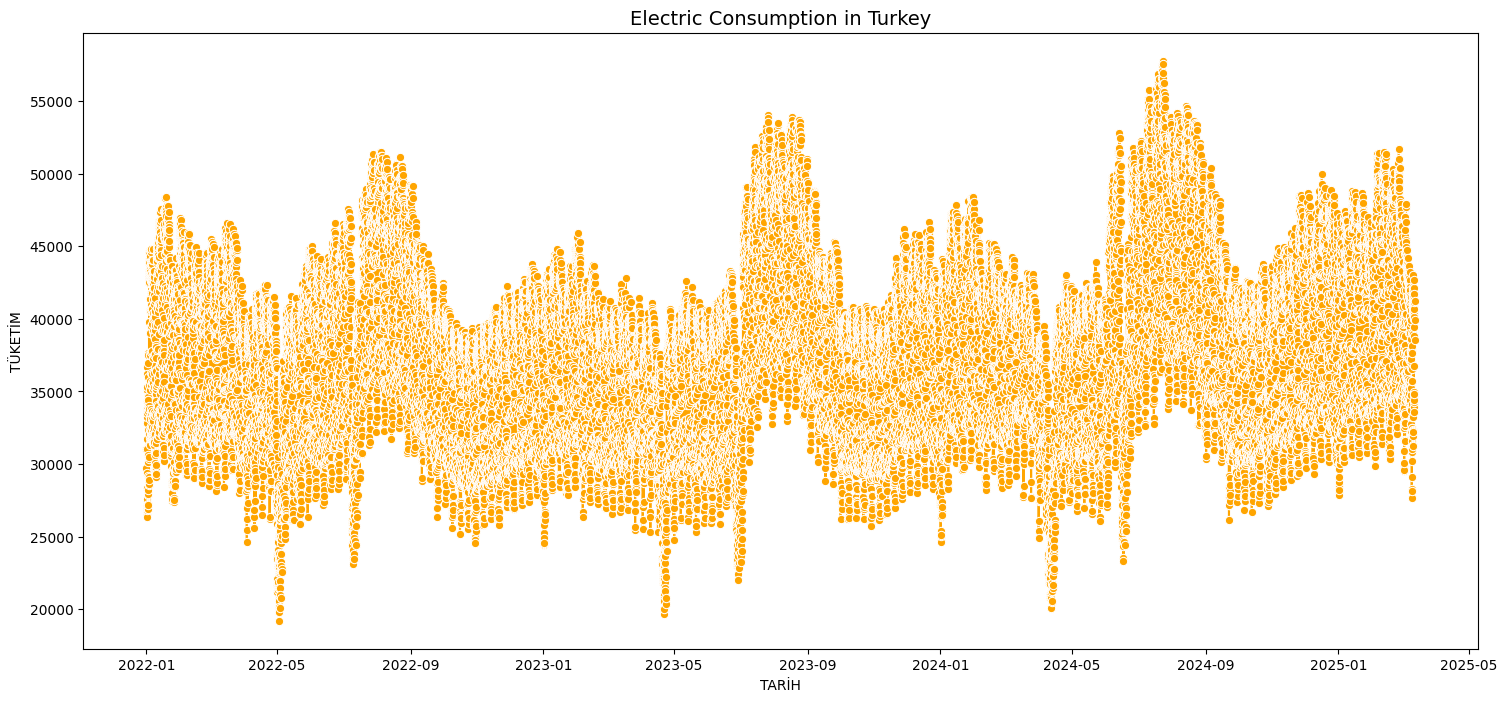

In [76]:
# Creata lineplot for electric consumption
plt.figure(figsize = (18, 8))
sns.lineplot(df[config.target_feature], color = "orange", marker = "o")
plt.title(f"Electric Consumption in Turkey", fontsize = 14)
plt.show()

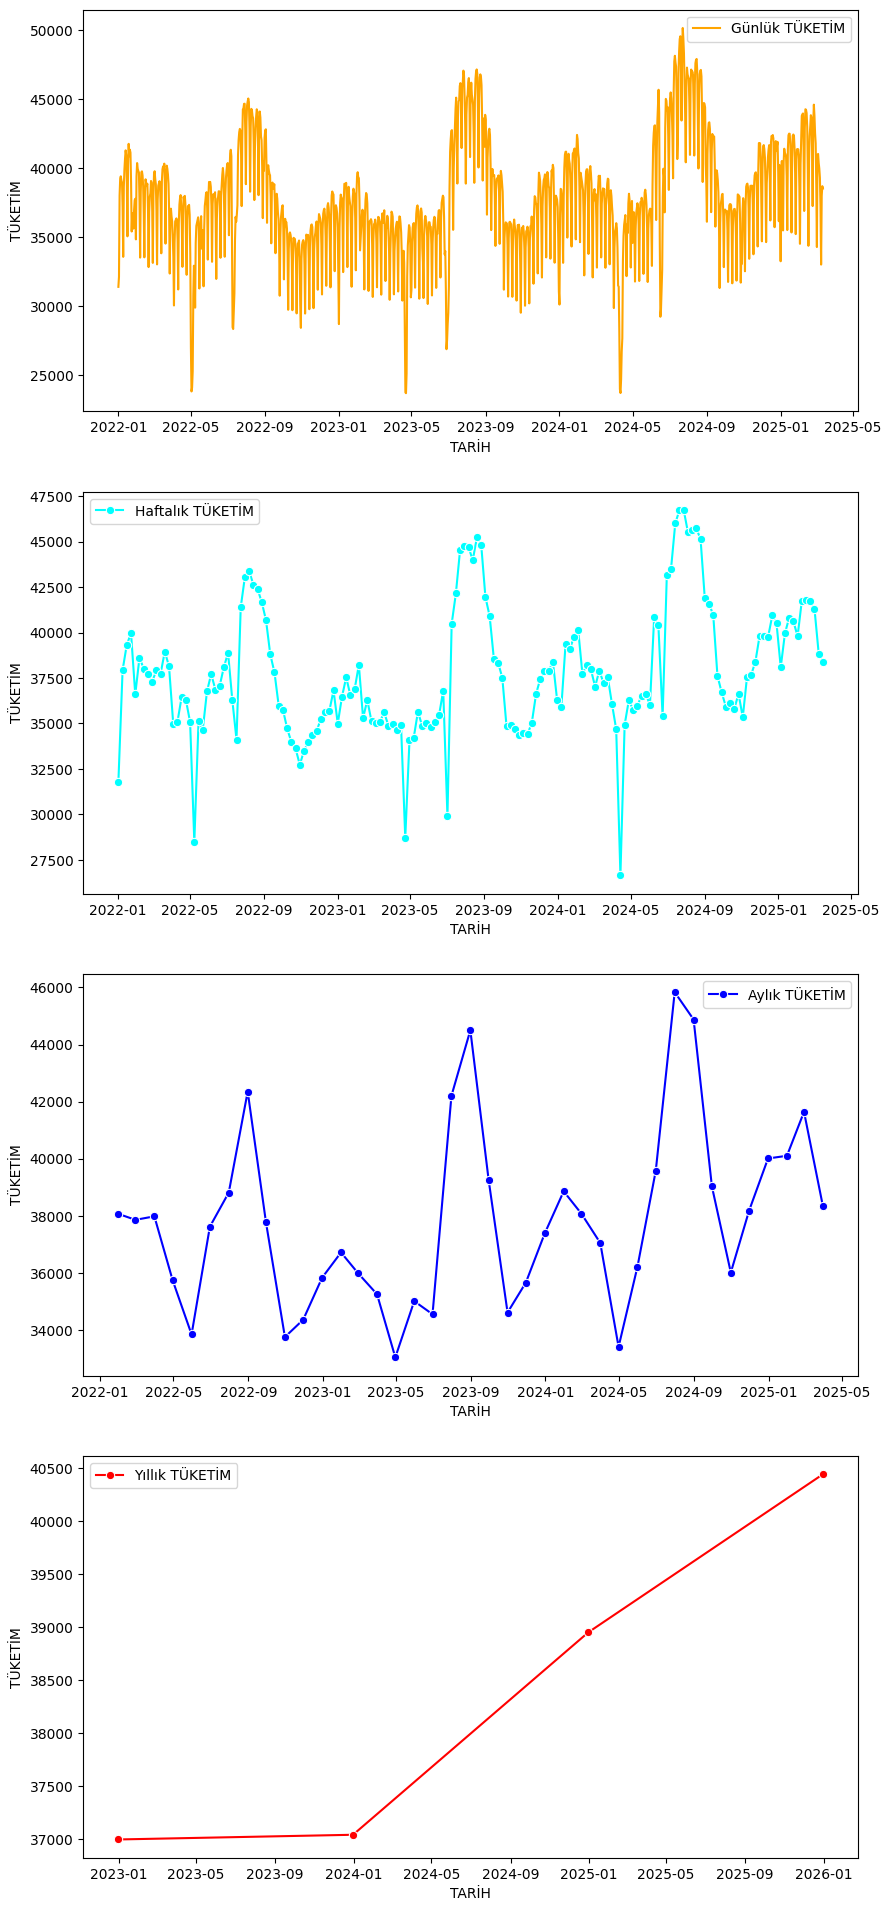

In [77]:
# Check means of daily, weekly, monthly and yearly trends
daily_mean    = df.resample("D").mean()[config.target_feature]
weekly_mean   = df.resample("W").mean()[config.target_feature]
monthly_mean  = df.resample("ME").mean()[config.target_feature]
yearly_mean   = df.resample("YE").mean()[config.target_feature]

fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (10, 24))

sns.lineplot(daily_mean, color = "orange", label = f"Günlük {config.target_feature}" , ax = ax[0])
sns.lineplot(weekly_mean, color = "cyan",  label = f"Haftalık {config.target_feature}", ax = ax[1], marker = "o")
sns.lineplot(monthly_mean, color = "blue", label = f"Aylık {config.target_feature}", ax = ax[2], marker = "o")
sns.lineplot(yearly_mean, color = "red",   label = f"Yıllık {config.target_feature}", ax = ax[3], marker = "o")


plt.legend()

plt.show()

Seasonal_decompose, zaman serisi verilerini bileşenlerine ayırmak için kullanılan klasik bir yöntemdir. Bu yöntem özellikle mevsimsellik (seasonality), trend ve gürültü (residual) analizlerinde kullanılır.

Additive: zaman_serisi = trend + seasonal + residual (additive model)

Multiplicative: zaman_serisi = trend * seasonal * residual

| Bileşen      | Açıklama                                                                            |
| ------------ | ----------------------------------------------------------------------------------- |
| **Trend**    | Verideki genel eğilim. Örneğin zamanla artan satışlar, düşen sıcaklıklar gibi.      |
| **Seasonal** | Belirli aralıklarla tekrar eden desenler. Örneğin haftalık, aylık, yıllık döngüler. |
| **Residual** | Trend ve seasonal çıkarıldıktan sonra kalan, rastgele veya açıklanamayan kısımdır.  |


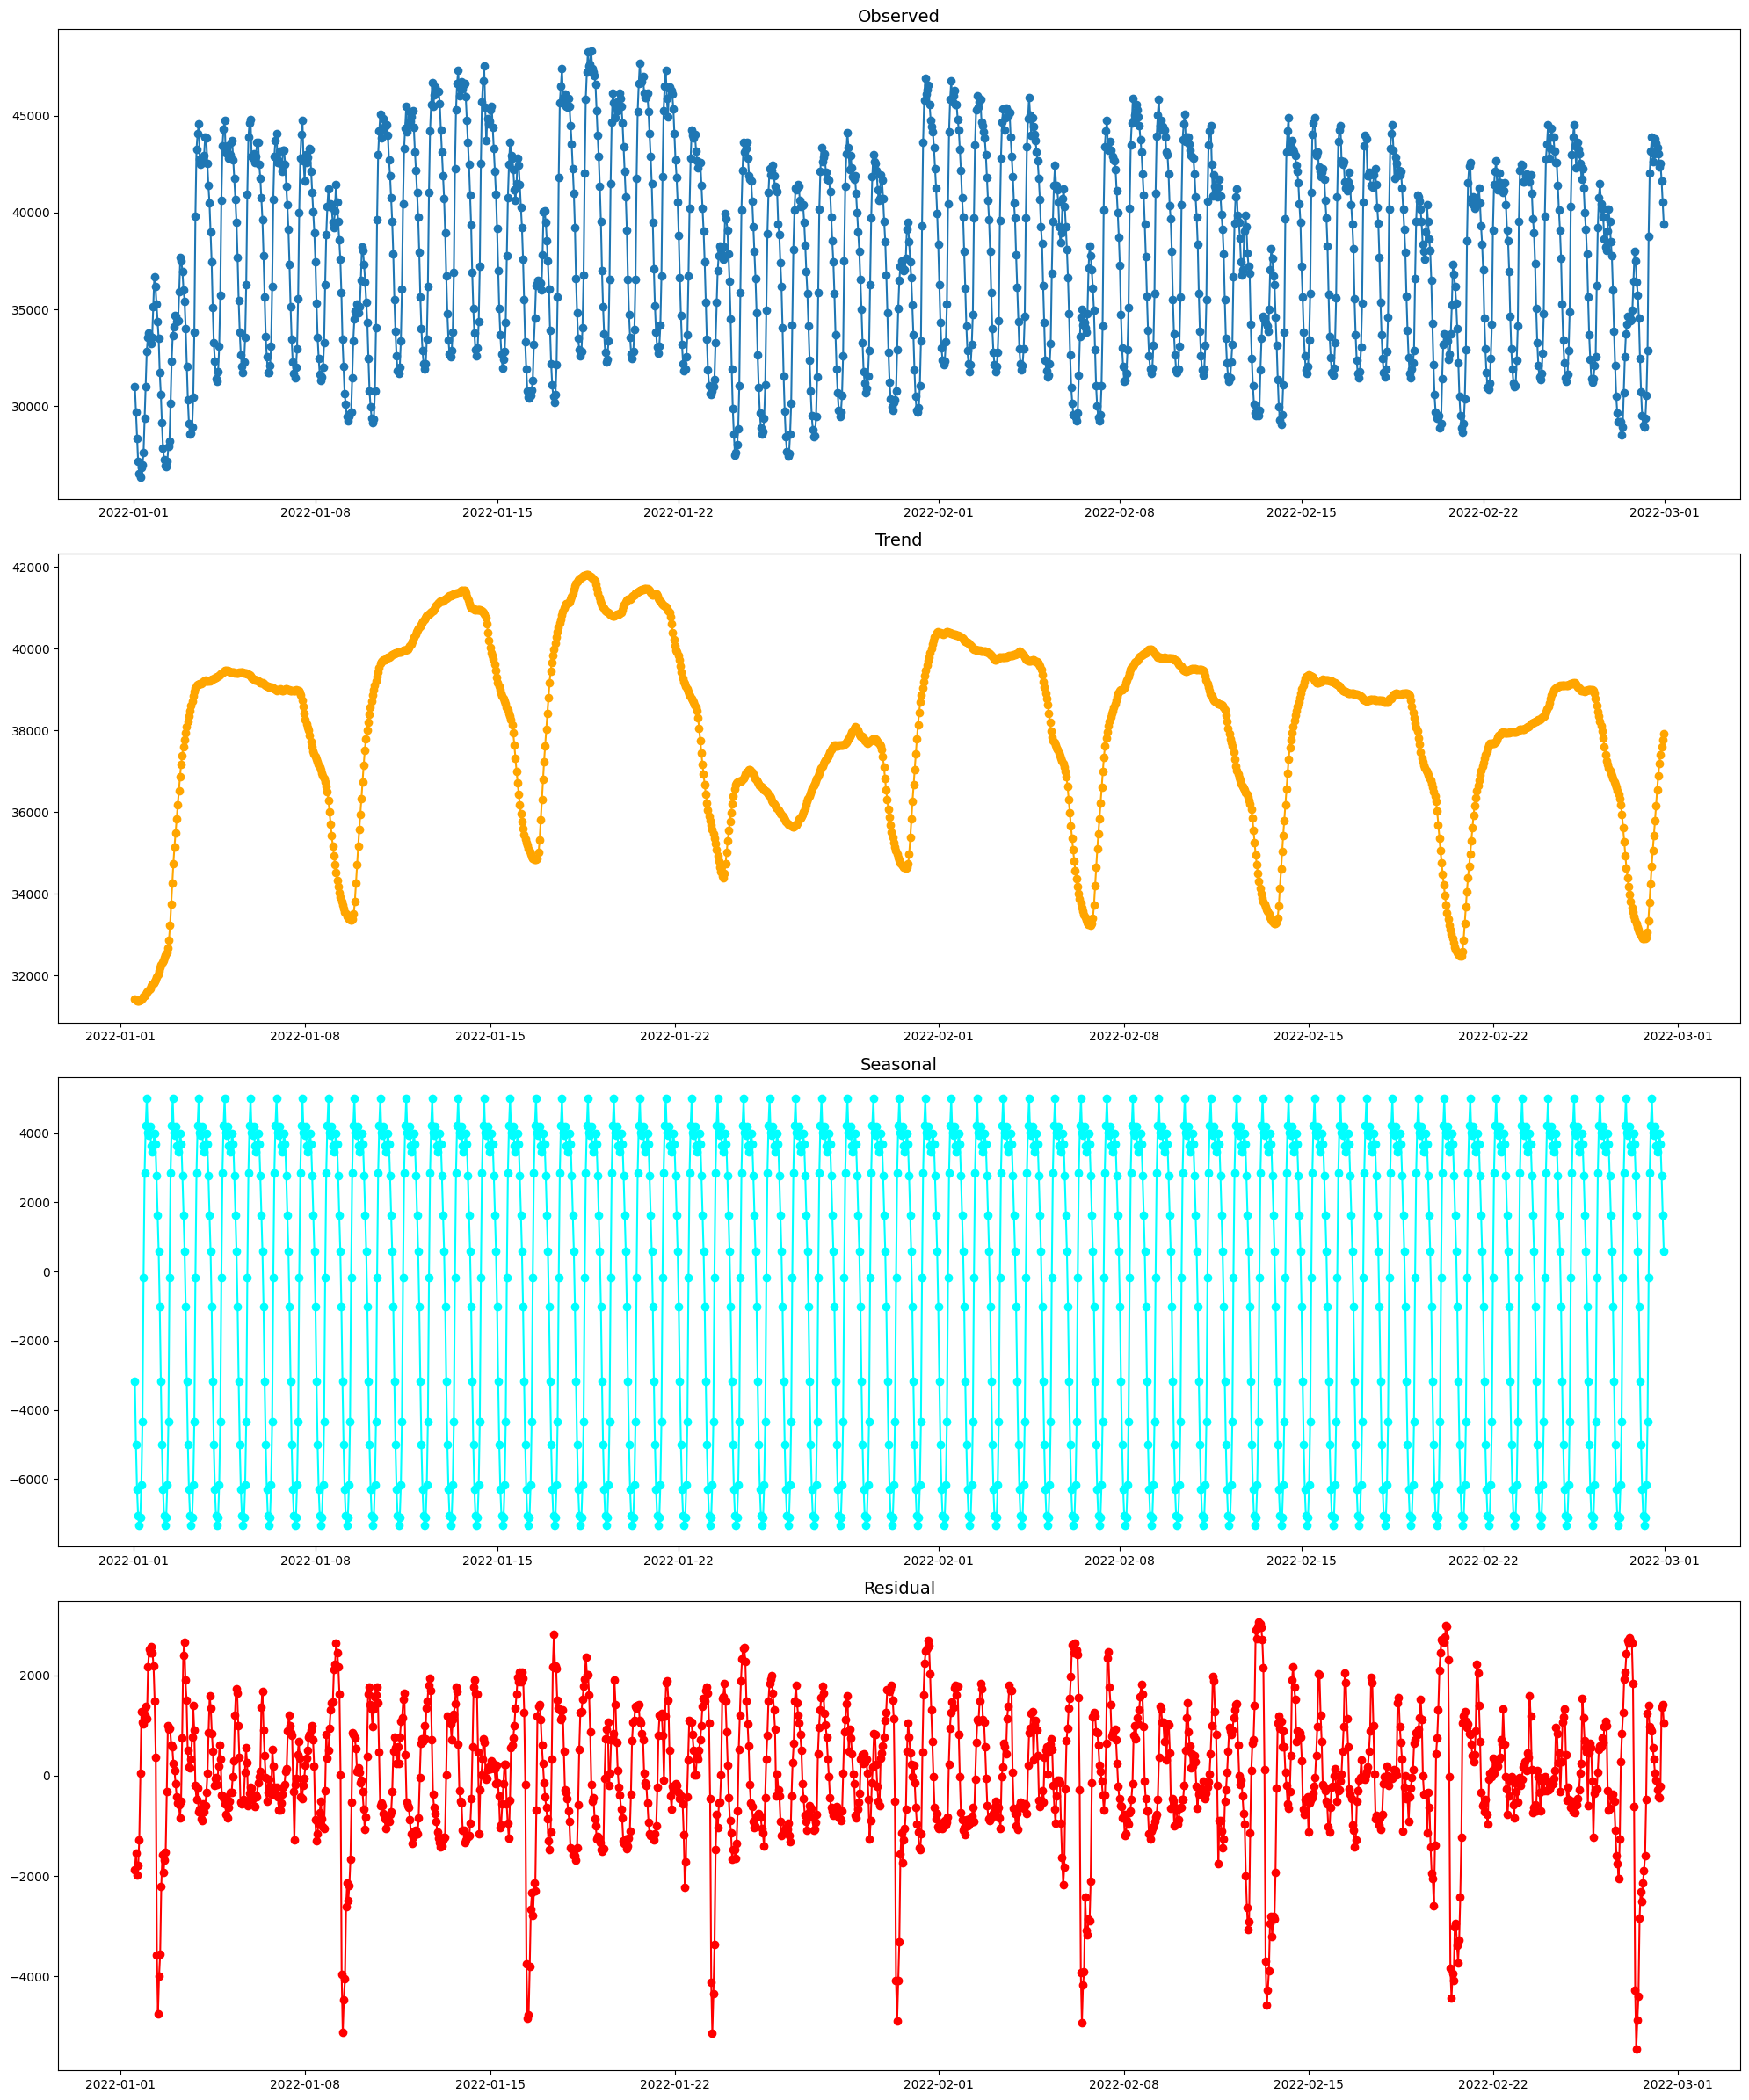

In [78]:
# Plot seasonal decompose 
result   = seasonal_decompose(df.loc[df.index < "2022-03-01", config.target_feature], model = "additive", period = 24)
observed = result.observed
trend    = result.trend
seasonal = result.seasonal
resid    = result.resid

fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (20, 24))

axes[0].plot(observed, marker = "o")
axes[0].set_title("Observed", fontsize = 14, loc = "center")

axes[1].plot(trend, color = "orange", marker = "o")
axes[1].set_title("Trend", fontsize = 14, loc = "center")

axes[2].plot(seasonal, color = "cyan", marker = "o")
axes[2].set_title("Seasonal", fontsize = 14, loc = "center")

axes[3].plot(resid, color = "red", marker = "o")
axes[3].set_title("Residual", fontsize = 14, loc = "center")

plt.tight_layout()
plt.show()

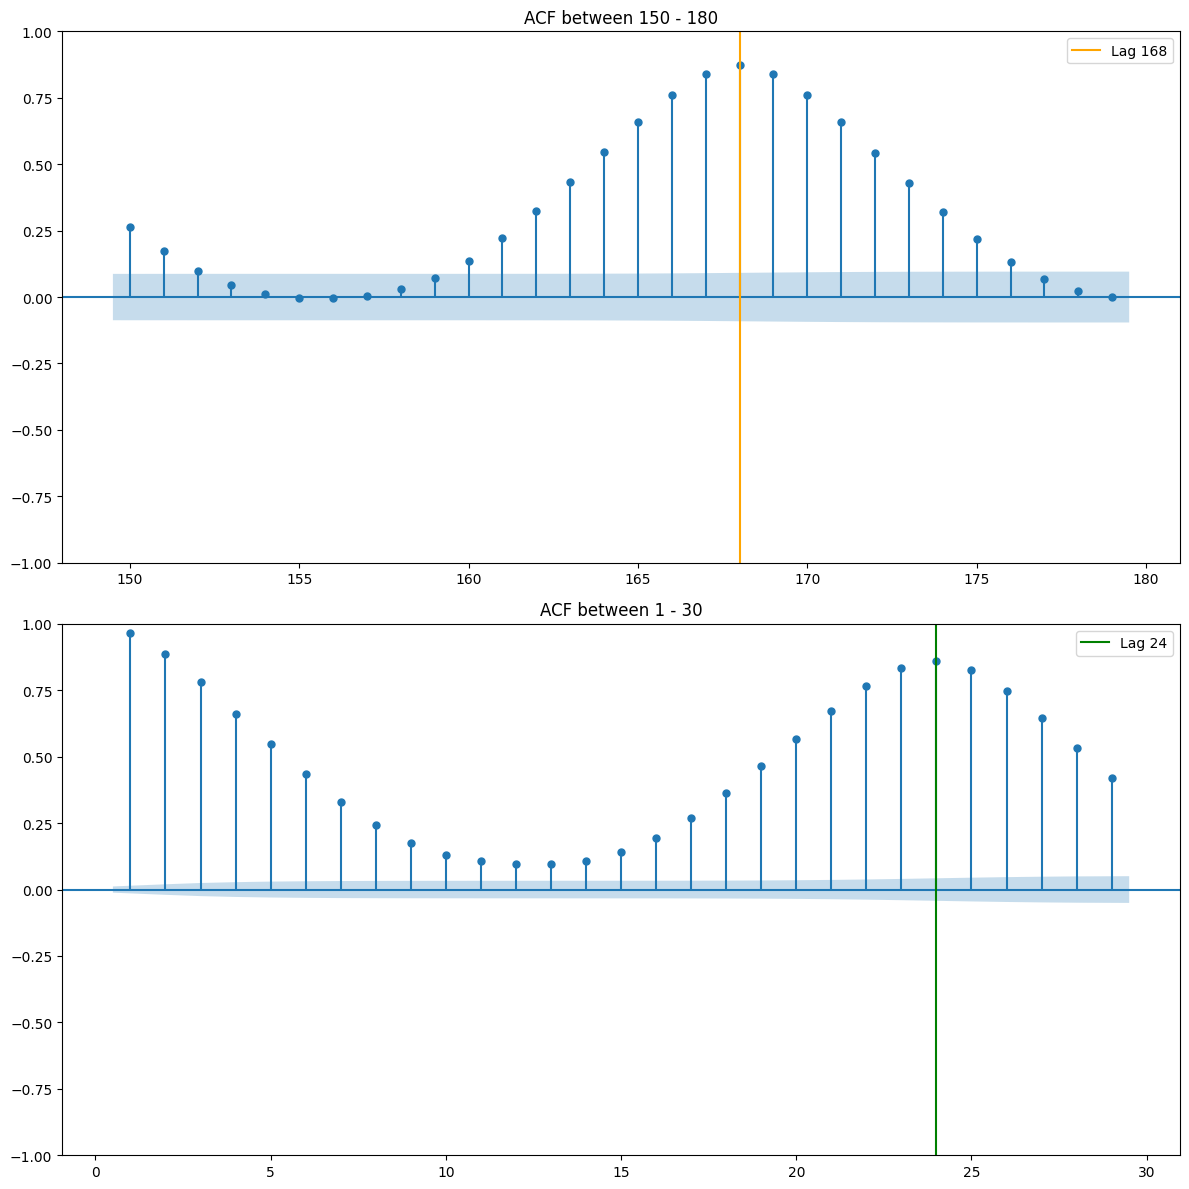

In [79]:
# Plot Auto Correlation 
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 12))

# ACF to 150-180
plot_acf(df[config.target_feature], lags = np.arange(150, 180, 1), ax = ax[0])
ax[0].axvline(168, color = "orange", label = "Lag 168")

# ACF to 0-30
plot_acf(df[config.target_feature], lags = np.arange(1, 30, 1), ax = ax[1])
ax[1].axvline(24, color = "green", label = "Lag 24")

# Set title
ax[0].set_title("ACF between 150 - 180")
ax[1].set_title("ACF between 1 - 30")
ax[0].legend()
ax[1].legend()
plt.tight_layout()


plt.show()

Seems like for 24 and 168 hours there is seasonality

In [80]:
# Apply Dickey Fuller Test
result = adfuller(df[config.target_feature], autolag = "AIC")

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Number of lags used:", result[2])
print("Number of observation used:", result[3])


print("Critical Values:")
for key, value in result[4].items():
    print(f"     {key}: {value}")

print("Information Criterion:", result[5])

if result[1] < 0.05:
    print("The series is stationary")
else: 
    print("The series is NOT stationary")

ADF Statistic: -10.979549077912328
p-value: 7.519019690105606e-20
Number of lags used: 50
Number of observation used: 27909
Critical Values:
     1%: -3.430584329483561
     5%: -2.8616435670127465
     10%: -2.5668251256099657
Information Criterion: 433539.3523240892
The series is stationary


# SARIMA Model

In [81]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [82]:
# Seperate train and test dataset
df_train, df_test = df[df.index.year < 2025].copy(), df[df.index.year == 2025].copy()

# MinMax Scale
minmax_scale = MinMaxScaler()
df_train[config.target_feature] = minmax_scale.fit_transform(df_train[config.target_feature].values.reshape(-1, 1))
df_test[config.target_feature] = minmax_scale.transform(df_test[config.target_feature].values.reshape(-1, 1))

In [83]:
#Find best parameters for sarıma model if you wish

if config.find_sarimax_params:
    SARIMA_model = pm.auto_arima(df_train[config.target_feature],
                                start_p = 1,
                                start_q = 1,
                                max_p = 1,
                                max_q = 1,
                                max_P = 1,
                                max_Q = 1, 
                                m = 24,
                                saesonal = True,
                                trace = True,
                                error_action = "ignore",
                                stepwise = True,
                                suppress_warnings = True,
                                max_order = 4  #p + q + P + Q <= max_order
                                )
    
    print(SARIMA_model.summary())

In [97]:
# Create sarimax model object
model_sarimax = SARIMAX(df_train["TÜKETİM"],
                       order = (1, 0, 1), #p, d, q
                       seasonal_order = (1, 1, 1, 24), # P, D, Q, S
                       trend = "c",
                       enforce_stationarity=True, # Logic: Allow non-stationary behavior if needed. I’ve already differenced the data if necessary. Real data may not be perfectly stationary
                       enforce_invertibility=True # Logic:  setting this to False allows the model to explore a broader space of parameter values that might fit your data better. Allows broader and more stable fitting
                       )
                        
# Fit sarimax model
result_sarimax = model_sarimax.fit()

# Attention Based LSTM Model

In [85]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score

In [86]:
def create_dataset_for_LSTM(dataframe: pd.DataFrame,
                           window_size: int,
                           forecast_horizon: int,
                           loc_target: int,
                           is_multivariate: bool = False):
    """
        This function create dataset to apply LSTM Model
    
    """
    X, y = [], []
    for i in range(len(dataframe) - window_size - forecast_horizon + 1):
        X.append(dataframe.iloc[i: i + window_size, loc_target].values)
        y.append(dataframe.iloc[i + window_size: i + window_size + forecast_horizon, loc_target].values)

    X, y = np.array(X), np.array(y)
    
    if not is_multivariate:
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y
    

In [87]:
loc_target = df.columns.get_loc(config.target_feature)

# Create dataset for train LSTM
X_train, y_train = create_dataset_for_LSTM(dataframe = df_train,
                                          window_size = config.window_size,
                                          forecast_horizon = config.forecast_horizon,
                                          loc_target = loc_target)


# Create datasets to test
X_test, y_test = create_dataset_for_LSTM(dataframe = df_test,
                                         window_size = config.window_size,
                                         forecast_horizon = config.forecast_horizon,
                                         loc_target = loc_target)

X_train.shape


(26231, 48, 1)

In [88]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units, return_attention=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.return_attention = return_attention
        
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = tf.keras.layers.Dense(self.units, use_bias=False)
        self.V = tf.keras.layers.Dense(1, use_bias=False)
        super(Attention, self).build(input_shape)
        
    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))  # (batch_size, time_steps, units)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)  # (batch_size, time_steps, 1)
        
        # Apply attention weights to input
        context_vector = attention_weights * inputs  # Broadcasting
        context_vector = tf.reduce_sum(context_vector, axis=1)  # (batch_size, features)
        
        if self.return_attention:
            return context_vector, tf.squeeze(attention_weights, -1)
        else:
            return context_vector

In [89]:
def build_LSTM_Attention_Model(sample_size: int,
                              forecast_horizon: int,
                              count_features = 1
                              ):

    inputs             = tf.keras.Input(shape = (sample_size, count_features))
    # Apply lstm layer
    lstm_layer         = layers.LSTM(64, return_sequences = True)(inputs)
    
    #Apply attention and get context vector and attention weights to analyze
    context_vector, attention_weights    = Attention(64)(lstm_layer)
    
    # Predict
    output_layer       = layers.Dense(forecast_horizon, activation = "linear")(context_vector)

    # Create model return predictions
    training_model = tf.keras.Model(inputs = inputs, outputs = output_layer)
    
    # Create model that returns both predictions and attention weights
    inference_model = tf.keras.Model(inputs=inputs, outputs=[output_layer, attention_weights])

    return training_model, inference_model

In [90]:
early_stopping = EarlyStopping(monitor             = "val_loss",
                              patience             = 100,
                              mode                 = "min",
                              restore_best_weights = True,
                              start_from_epoch     = 100,
                              #min_delta            = 5e-6
                              )


reduce_LR = ReduceLROnPlateau(monitor  = "val_loss",
                             factor    = 0.2,
                             patience  = 30,
                             min_lr    = 1e-4)


model_checkpoint = ModelCheckpoint(filepath      = "/kaggle/working/best_bilstm_model.keras",
                                  monitor        = "val_loss",
                                  save_best_only = True,
                                  mode           = "min",
                                  )

In [91]:
model_atlstm, inference_atlstm_model = build_LSTM_Attention_Model(sample_size = X_train.shape[1],
                                           forecast_horizon = config.forecast_horizon)


model_atlstm.compile(optimizer = Adam(learning_rate = 1e-2),
                    loss = "mse",
                    metrics = ["mae"])

In [92]:
# Split train dataset as train and validation dataset. There are 2192 hours in three monts
X_train, X_val, y_train, y_val = X_train[:-2192], X_train[-2192:], y_train[:-2192], y_train[-2192:]

In [93]:
tf.random.set_seed(42)

# Create atlstm model
if config.create_atlstm_model:
    history_atlstm = model_atlstm.fit(X_train, y_train,
                                     batch_size = 64,
                                     epochs = 5000,
                                     validation_data = (X_val, y_val),
                                     callbacks = [early_stopping, reduce_LR, model_checkpoint],
                                     verbose = 2)

# Load saved atlstm model
else:
    model_atlstm = tf.keras.models.load_model(config.dir_atlstm_model,
                                             custom_objects={'Attention': Attention})

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


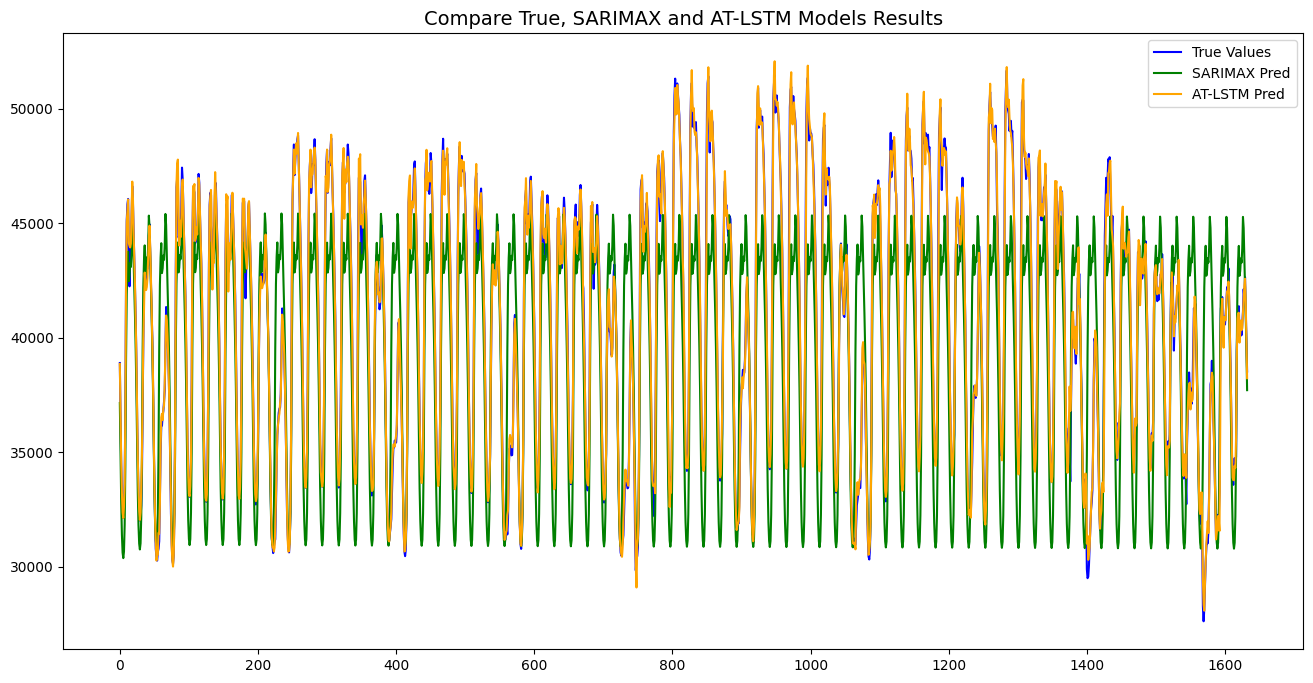

In [98]:
# predict test set with sarima and attention based lstm model

true_values = minmax_scale.inverse_transform(df_test[config.target_feature].values.reshape(-1, 1)).reshape(df_test.shape[0],)[config.window_size:]

predictions_atlstm = model_atlstm.predict(X_test)
predictions_atlstm = minmax_scale.inverse_transform(predictions_atlstm).reshape(predictions_atlstm.shape[0],)

predictions_sarimax = result_sarimax.get_forecast(steps=df_test.shape[0])
predictions_sarimax_mean = predictions_sarimax.predicted_mean
predictions_sarimax_mean = minmax_scale.inverse_transform(predictions_sarimax_mean.values.reshape(-1, 1)).reshape(predictions_sarimax_mean.shape[0],)[config.window_size:]


#Plot true and predicted values 
plt.figure(figsize = (16 ,8))
sns.lineplot(true_values, color = "blue", label="True Values")
sns.lineplot(predictions_sarimax_mean, color = "green", label = "SARIMAX Pred")
sns.lineplot(predictions_atlstm, color = "orange", label = "AT-LSTM Pred")

plt.legend()
plt.title("Compare True, SARIMAX and AT-LSTM Models Results", fontsize = 14, loc = "center")
plt.show()

In [99]:
# Calculate Meab Absolute Error for Models
atlstm_model_mae = mean_absolute_error(y_true = true_values, y_pred = predictions_atlstm)
sarima_model_mae = mean_absolute_error(y_true = true_values, y_pred = predictions_sarimax_mean)

print(f"Mean Absolute Error AT-LSTM: {atlstm_model_mae}")
print(f"Mean Absolute Error SARIMA: {sarima_model_mae}")

# Calculate R2 Score for Models
atlstm_model_r2 = r2_score(y_true = true_values, y_pred = predictions_atlstm)
sarima_model_r2 = r2_score(y_true = true_values, y_pred = predictions_sarimax_mean)

print(f"R2 Score AT-LSTM: {atlstm_model_r2}")
print(f"R2 Score SARIMA: {sarima_model_r2}")

Mean Absolute Error AT-LSTM: 325.0995852150949
Mean Absolute Error SARIMA: 3014.6535670376948
R2 Score AT-LSTM: 0.9919501885501001
R2 Score SARIMA: 0.5621846798130044


Attention weights shape: (1633, 48)


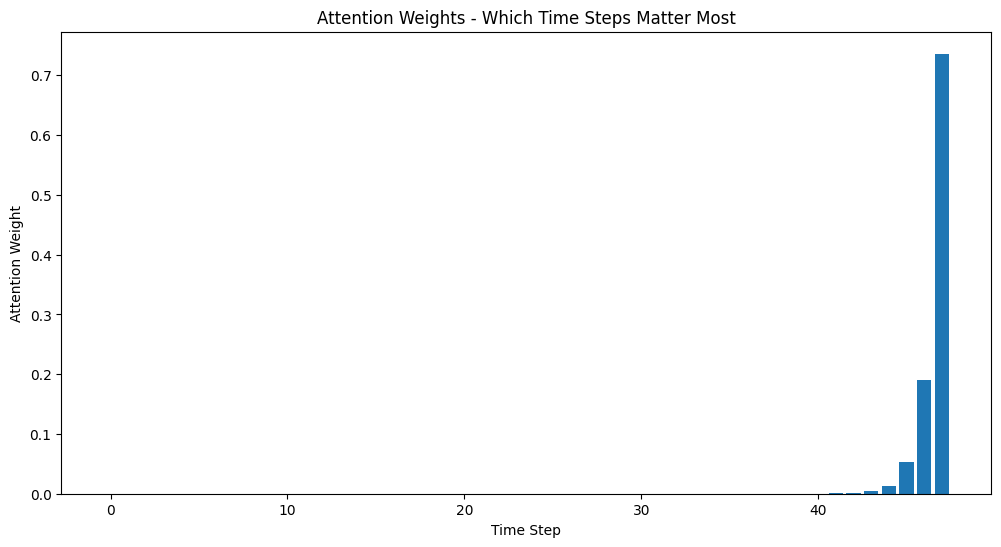

In [96]:
# Transfer trained weights to inference model
inference_atlstm_model.set_weights(model_atlstm.get_weights())

# Get attention weights!
predictions, attention_weights = inference_atlstm_model(X_test)

# 5. Analyze which time steps matter most
print("Attention weights shape:", attention_weights.shape)

mean_attention_weights = np.mean(attention_weights, axis = 0)

plt.figure(figsize=(12, 6))
plt.bar(range(len(attention_weights[0])), mean_attention_weights)
plt.title('Attention Weights - Which Time Steps Matter Most')
plt.xlabel('Time Step')
plt.ylabel('Attention Weight')
plt.show()